# Baseline Model for Data Scientist Salaries Classification

## Setup Packages

### Install TensorFlow

In [1]:
!pip install tensorflow

In [2]:
import tensorflow as tf
tf.compat.v1.disable_v2_behavior()

import numpy as np

Instructions for updating:
non-resource variables are not supported in the long term


### Install Other Libraries

In [3]:
import datetime
from datetime import datetime

from numpy.random import RandomState
import pandas as pd
from sklearn import preprocessing


## Setup Data

### Categorize Salaries

,timestamp,company,level,title,totalyearlycompensation,location,yearsofexperience,yearsatcompany,tag,basesalary,...,Doctorate_Degree,Highschool,Some_College,Race_Asian,Race_White,Race_Two_Or_More,Race_Black,Race_Hispanic,Race,Education
0,6/7/2017 11:33:27,Oracle,L3,Product Manager,127000,"Redwood City, CA",1.5,1.5,NaN,107000.0,...,0,0,0,0,0,0,0,0,NaN,NaN
1,6/10/2017 17:11:29,eBay,SE 2,Software Engineer,100000,"San Francisco, CA",5.0,3.0,NaN,0.0,...,0,0,0,0,0,0,0,0,NaN,NaN
2,6/11/2017 14:53:57,Amazon,L7,Product Manager,310000,"Seattle, WA",8.0,0.0,NaN,155000.0,...,0,0,0,0,0,0,0,0,NaN,NaN
3,6/17/2017 0:23:14,Apple,M1,Software Engineering Manager,372000,"Sunnyvale, CA",7.0,5.0,NaN,157000.0,...,0,0,0,0,0,0,0,0,NaN,NaN
4,6/20/2017 10:58:51,Microsoft,60,Software Engineer,157000,"Mountain View, CA",5.0,3.0,NaN,0.0,...,0,0,0,0,0,0,0,0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
62637,9/9/2018 11:52:32,Google,T4,Software Engineer,327000,"Seattle, WA",10.0,1.0,Distributed Systems (Back-End),155000.0,...,0,0,0,0,0,0,0,0,NaN,NaN
62638,9/13/2018 8:23:32,Microsoft,62,Software Engineer,237000,"Redmond, WA",2.0,2.0,Full Stack,146900.0,...,0,0,0,0,0,0,0,0,NaN,NaN
62639,9/13/2018 14:35:59,MSFT,63,Software Engineer,220000,"Seattle, WA",14.0,12.0,Full Stack,157000.0,...,0,0,0,0,0,0,0,0,NaN,NaN
62640,9/16/2018 16:10:35,Salesforce,Lead MTS,Software Engineer,280000,"San Francisco, CA",8.0,4.0,iOS,194688.0,...,0,0,0,0,0,0,0,0,NaN,NaN


<AxesSubplot:>

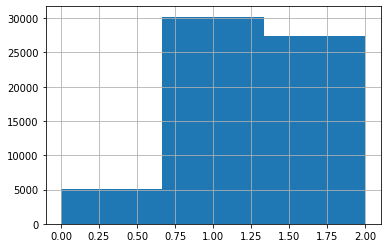

In [4]:
df = pd.read_csv('salaries.csv')
display(df)

salary_ranges = [0,80000,200000,np.inf]
df['salaryrange'] = pd.cut(df.totalyearlycompensation, salary_ranges, labels=[0,1,2], include_lowest=True)

df['salaryrange'].hist(bins=len(salary_ranges) - 1)

In [5]:
df.salaryrange.value_counts()

1    30203
2    27429
0     5010
Name: salaryrange, dtype: int64

### Make All Values Into Integers

In [6]:
# encode timestamp into integers, by year and month
def timestamp_to_int(timestamp):
    dt_obj = datetime.strptime(timestamp.split(' ')[0], '%m/%d/%Y')
    return (100 * dt_obj.year) + (dt_obj.month)

df['timestamp'] = df['timestamp'].apply(timestamp_to_int)

# turn company names to lowercase and encode as integers
df['company'] = df['company'].apply(lambda t: str(t).lower())
df['company'] = pd.Categorical(pd.factorize(df['company'])[0])

# encode level as integer
df['level'] = pd.Categorical(pd.factorize(df['level'])[0])

# encode title as integer
df['title'] = pd.Categorical(pd.factorize(df['title'])[0])

# encode tag as integer
df['tag'] = pd.Categorical(pd.factorize(df['tag'])[0])

# encode gender as integer
df['gender'] = pd.Categorical(pd.factorize(df['gender'])[0])

# encode Race as integer
df['Race'] = pd.Categorical(pd.factorize(df['Race'])[0])

# encode Education as integer
df['Education'] = pd.Categorical(pd.factorize(df['Education'])[0])


### Remove Rows

In [7]:
df = df[df['gender'] != -1]
df = df[df['Education'] != -1]
df = df[df['Race'] != -1]
df = df[(50000 < df['totalyearlycompensation']) & (df['totalyearlycompensation'] < 500000)]

### Drop Columns

In [8]:
# make model predict without knowledge of the totalyearlycompensation
df.drop('totalyearlycompensation', axis=1, inplace=True)

# location information is already encoded as an integer in 'cityid'
df.drop('location', axis=1, inplace=True)

# make model predict without knowledge of the base salary
df.drop('basesalary', axis=1, inplace=True)

# 'otherdetails' column requires NLP to interpret
df.drop('otherdetails', axis=1, inplace=True)

# 'rowNumber' column is unnecessary
df.drop('rowNumber', axis=1, inplace=True)

# education information is entirely encoded in the 'Education' column already
df.drop('Masters_Degree', axis=1, inplace=True)
df.drop('Bachelors_Degree', axis=1, inplace=True)
df.drop('Doctorate_Degree', axis=1, inplace=True)
df.drop('Highschool', axis=1, inplace=True)
df.drop('Some_College', axis=1, inplace=True)

# race information is entirely encoded in the 'Race' column already
df.drop('Race_Asian', axis=1, inplace=True)
df.drop('Race_White', axis=1, inplace=True)
df.drop('Race_Two_Or_More', axis=1, inplace=True)
df.drop('Race_Black', axis=1, inplace=True)
df.drop('Race_Hispanic', axis=1, inplace=True)

### Training/Testing Data

In [9]:
drop_indices = np.random.choice(df.index, len(df.index) % 1250, replace=False)
df.drop(drop_indices, inplace=True)

rng = RandomState()

df_train = df.sample(frac=0.8, random_state=rng)
df_test = df.loc[~df.index.isin(df_train.index)]

print('Whole Dataset')
display(df)
print('Training Dataset')
display(df_train)
print('Testing Dataset')
display(df_test)

Whole Dataset


,timestamp,company,level,title,yearsofexperience,yearsatcompany,tag,stockgrantvalue,bonus,gender,cityid,dmaid,Race,Education,salaryrange
15710,202001,9,11,1,5.0,5.0,1,145000.0,45000.0,0,7472,807.0,1,0,2
23532,202007,4,46,1,3.0,2.0,4,1000.0,11000.0,0,11521,819.0,3,2,1
23533,202007,9,12,1,6.0,6.0,0,125000.0,36000.0,0,7413,807.0,1,2,2
23534,202007,4,7,1,4.0,4.0,3,38000.0,20000.0,0,11527,819.0,1,1,2
23535,202007,807,62,1,5.0,0.0,0,22000.0,0.0,0,7419,807.0,0,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61824,202108,790,1410,1,0.0,0.0,1,0.0,15000.0,0,41795,0.0,1,2,0
61826,202108,449,133,1,2.0,2.0,0,0.0,0.0,0,7839,524.0,1,2,1
61828,202108,806,131,1,3.0,3.0,1,0.0,5000.0,0,35382,521.0,0,2,1
61830,202108,2,11,0,9.0,0.0,1464,46000.0,45000.0,1,11527,819.0,1,2,2


Training Dataset


,timestamp,company,level,title,yearsofexperience,yearsatcompany,tag,stockgrantvalue,bonus,gender,cityid,dmaid,Race,Education,salaryrange
31487,202009,5,308,1,0.0,0.0,3,25000.0,14000.0,0,7419,807.0,1,2,1
51867,202105,699,1585,1,15.0,13.0,6,4000.0,22000.0,0,8198,602.0,1,2,1
31784,202010,2,11,0,9.0,3.0,1458,210000.0,0.0,1,11527,819.0,4,2,2
28644,202009,290,315,1,5.0,0.0,4,24000.0,16000.0,0,7275,803.0,0,2,1
32937,202010,837,301,4,2.0,0.0,20,0.0,26000.0,0,10919,659.0,0,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26490,202008,806,1615,1,0.0,0.0,228,0.0,0.0,0,7548,751.0,0,2,0
53605,202106,177,6,2,8.0,6.0,45,12000.0,20000.0,0,1206,0.0,0,2,1
60927,202108,139,790,3,1.0,1.0,3008,0.0,6000.0,0,9920,501.0,1,1,1
54782,202106,4,16,1,8.0,8.0,1,50000.0,30000.0,0,11521,819.0,1,1,2


Testing Dataset


,timestamp,company,level,title,yearsofexperience,yearsatcompany,tag,stockgrantvalue,bonus,gender,cityid,dmaid,Race,Education,salaryrange
23534,202007,4,7,1,4.0,4.0,3,38000.0,20000.0,0,11527,819.0,1,1,2
23557,202007,388,359,1,9.0,4.0,4,0.0,10000.0,0,10965,635.0,4,1,1
23558,202007,4,16,1,12.0,0.0,1280,63000.0,50000.0,0,7419,807.0,1,2,2
23565,202007,790,1338,1,10.0,0.0,0,225000.0,54000.0,1,7322,807.0,1,1,2
23566,202007,212,613,1,10.0,6.0,1,0.0,10000.0,0,7275,803.0,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61769,202108,35,135,1,0.0,0.0,7,13000.0,8000.0,0,7416,825.0,1,1,1
61773,202108,4,8,0,2.0,0.0,36,30000.0,15000.0,1,11527,819.0,3,2,1
61775,202108,641,15,1,7.0,1.0,6,23000.0,20000.0,0,10278,535.0,0,3,1
61779,202108,6,31,1,2.0,2.0,1,90000.0,16000.0,0,10182,501.0,1,2,2


In [10]:
train_data = df_train.loc[:, df_train.columns != 'salaryrange'].to_numpy()
test_data = df_test.loc[:, df_test.columns != 'salaryrange'].to_numpy()

train_labels = df_train['salaryrange'].to_numpy()
test_labels = df_test['salaryrange'].to_numpy()

train_labels = tf.keras.utils.to_categorical(train_labels, num_classes=len(salary_ranges) - 1)
test_labels = tf.keras.utils.to_categorical(test_labels, num_classes=len(salary_ranges) - 1)

## Make the Model

### Set Variables

In [11]:
epochs = 7
batch_size = 250

### Add Layers to Model

In [12]:
model = tf.keras.Sequential([
    tf.keras.layers.Dense(256, activation='sigmoid'),
    tf.keras.layers.Dense(128, activation='sigmoid'),
    tf.keras.layers.Dense(32, activation='sigmoid'),
    tf.keras.layers.Dense(len(salary_ranges) - 1, activation='softmax')
])

In [13]:
model.compile(optimizer=tf.keras.optimizers.Adam(5e-4), loss='categorical_crossentropy', metrics=['accuracy'])
model.build(train_data.shape)
model.summary()
model.fit(train_data, train_labels, epochs=epochs, validation_data=(test_data, test_labels), batch_size=batch_size)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               multiple                  3840      
                                                                 
 dense_1 (Dense)             multiple                  32896     
                                                                 
 dense_2 (Dense)             multiple                  4128      
                                                                 
 dense_3 (Dense)             multiple                  99        
                                                                 
Total params: 40,963
Trainable params: 40,963
Non-trainable params: 0
_________________________________________________________________
Train on 15000 samples, validate on 3750 samples
Epoch 1/7
 7750/15000 [==============>...............] - ETA: 0s - loss: 0.8452 - acc: 0.5714

2022-05-09 23:19:09.122409: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


15000/15000 [==============================] - 0s 13us/sample - loss: 0.7820 - acc: 0.6701 - val_loss: 0.6434 - val_acc: 0.8005
Epoch 2/7
15000/15000 [==============================] - 0s 7us/sample - loss: 0.5571 - acc: 0.8157 - val_loss: 0.4977 - val_acc: 0.8293
Epoch 3/7
 9000/15000 [=================>............] - ETA: 0s - loss: 0.4883 - acc: 0.8277

/opt/anaconda3/lib/python3.9/site-packages/keras/engine/training_v1.py:2057: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


15000/15000 [==============================] - 0s 7us/sample - loss: 0.4799 - acc: 0.8272 - val_loss: 0.4649 - val_acc: 0.8347
Epoch 4/7
15000/15000 [==============================] - 0s 7us/sample - loss: 0.4563 - acc: 0.8319 - val_loss: 0.4469 - val_acc: 0.8392
Epoch 5/7
15000/15000 [==============================] - 0s 7us/sample - loss: 0.4451 - acc: 0.8328 - val_loss: 0.4425 - val_acc: 0.8379
Epoch 6/7
15000/15000 [==============================] - 0s 7us/sample - loss: 0.4413 - acc: 0.8319 - val_loss: 0.4345 - val_acc: 0.8349
Epoch 7/7
15000/15000 [==============================] - 0s 7us/sample - loss: 0.4322 - acc: 0.8339 - val_loss: 0.4297 - val_acc: 0.8360


In [14]:
model_loss, model_metric = model.evaluate(test_data, test_labels, batch_size=batch_size)
print(model_metric)

0.836
